# Setup

## Requirements

Run this code in your terminal : `pip install -r requirements.txt`

## Datafiles

The Olympic dataset is pulled from Kaggle at the following URL: [https://www.kaggle.com/datasets/josephcheng123456/olympic-historical-dataset-from-olympediaorg](https://www.kaggle.com/datasets/josephcheng123456/olympic-historical-dataset-from-olympediaorg). You can also download it [from Github here](https://github.com/josephwccheng/olympedia_web_scraping/tree/main/data) - prefer the data from the folder named "cleaned_data".

This dataset was built by scraping the [Olympedia](https://www.olympedia.org/) website, which contains extensive data from the 1896 Athens Summer Olympics to the Beijing 2022 Winter Olympics. The data used to create the website is the product of years of work by a group of dedicated Olympic historians and statisticians.

The dataset contains the following files:

- Olympic_Athlete_Event_Results: Connects athletes to the events they competed in and their finishing positions.
- Olympic_Athlete_Bio: Details of athletes including date of birth, height, weight, and descriptions.
- Olympic_Results: In-depth details of the Olympic events.
- Olympic_Games_Medal_Tally : Yearly number of medals collected by each country
- Olympic_Games: List of all the Olympics, including the year and location.

This data is downloaded and stored in the `data/gh_olympic_data` directory.

**In addition to the Olympedia dataset**, I also used other external sources of data:

- Paralympics_Medal_Athlete: Paralympic data about athletes who won medals - this was supplied to us by the competition organizers. 
- Olympic_Country: List of all countries that have participated in the Olympics.

- I edited the original Olympedia scraping script to collect additional information about the yearly number of participants and disciplines included in each game. The script can be found [here](https://github.com/josephwccheng/olympedia_web_scraping).

- World Bank World Development Indicators: Main development indicators extracted directly from the World Bank Database. The dataset can be found [here](https://www.kaggle.com/datasets/nicolasgonzalezmunoz/world-bank-world-development-indicators).

- World Energy Consumption: Consumption of energy by different countries. The dataset can be found [here](https://www.kaggle.com/datasets/pralabhpoudel/world-energy-consumption).

- Yearly descriptive statistics compiled by the UN: Excel files with annual estimates and standard projection scenarios, including population indicators like life expectancy, total births, mean age, etc. The dataset can be found [here](https://population.un.org/wpp/Download/Standard/MostUsed/).

I performed some Excel manipulations to select only the most interesting columns from these additional datasets, and the resulting files are stored in the `data/new_data` directory.


# Step one - build a main datafile

## Data wrangling

In [3]:
import pandas as pd
import numpy as np

In [4]:
olympic_df = pd.read_csv("data/gh_olympic_data/Olympics_Games.csv")

# Only keep held games and exclude the 1906 Intercalated Games and the 1956 equestrian games
olympic_df = olympic_df[~olympic_df["edition_id"].isin([4, 48])]
olympic_df = olympic_df[olympic_df["isHeld"]=="na"]

# Calculate duration (diff between end_date and start_date)
date_columns = ["competition_start_date", "competition_end_date"]

for col in date_columns:
    olympic_df[col] = pd.to_datetime(olympic_df[col], errors="coerce")

olympic_df["duration_days"] = (olympic_df["competition_end_date"] - olympic_df["competition_start_date"]).dt.days

# create winter/summer flag column
olympic_df["season"] = np.where(olympic_df["edition"].str.lower().str.contains("summer"), "summer", "winter")

# preview
olympic_df.head(3)


,edition,edition_id,edition_url,year,city,country_flag_url,country_noc,start_date,end_date,isHeld,competition_start_date,competition_end_date,duration_days,season
0,1896 Summer Olympics,1,/editions/1,1896,Athina,/images/flags/GRE.png,GRE,1896-04-06,1896-04-15,na,1896-04-06,1896-04-13,7.0,summer
1,1900 Summer Olympics,2,/editions/2,1900,Paris,/images/flags/FRA.png,FRA,na,na,na,1900-05-14,1900-10-28,167.0,summer
2,1904 Summer Olympics,3,/editions/3,1904,St. Louis,/images/flags/USA.png,USA,1904-05-14,na,na,1904-07-01,1904-11-23,145.0,summer


In [5]:
# bring in additional scraped data
new_cols = pd.read_excel("data/new_data/olympic_games_meta_stats.xlsx", index_col=0 )

# join by "olympics_name" in new_cols and "edition" in olympic_df
olympic_df = olympic_df.merge(new_cols, left_on="edition", right_on="olympics_name", how="left")

# remove columns
olympic_df = olympic_df.drop(columns=["isHeld", "edition", "start_date", "end_date", "olympics_name"])

# country name of host city
olympic_country_codes = pd.read_excel("data/official_data/Olympics_Country.xlsx")

# join with olympic_df on country_noc
olympic_df = olympic_df.merge(olympic_country_codes, on="country_noc", how="left")

# preview

olympic_df.head(3)

,edition_id,edition_url,year,city,country_flag_url,country_noc,competition_start_date,competition_end_date,duration_days,season,num_participants,num_countries,num_medal_events,num_disciplines,country
0,1,/editions/1,1896,Athina,/images/flags/GRE.png,GRE,1896-04-06,1896-04-13,7.0,summer,176.0,13.0,43.0,10.0,Greece
1,2,/editions/2,1900,Paris,/images/flags/FRA.png,FRA,1900-05-14,1900-10-28,167.0,summer,1239.0,27.0,95.0,22.0,France
2,3,/editions/3,1904,St. Louis,/images/flags/USA.png,USA,1904-07-01,1904-11-23,145.0,summer,650.0,10.0,95.0,18.0,United States


### Feature engineering

#### Distance from Athens and previous cities

In [6]:
# pull distance from Athens from other data

from googlemaps import Client as GoogleMaps
import googlemaps
import geopy.distance

# if distance file exists, load it directly
try:
    distances = pd.read_excel("data/new_data/olympic_games_distances.xlsx", index_col=0)
    print("Loaded distances from file")
    # add data to olympic_df
    olympic_df = olympic_df.join(pd.DataFrame(distances))
except:
    # Initialize Google Maps API
    google_maps_api = "ADD YOUR API KEY FOR GOOGLE MAPS HERE"
    gmaps = googlemaps.Client(key=google_maps_api)
    
    # Get Athens location
    geocode_result = gmaps.geocode("Athina")
    lat_athens = geocode_result[0]['geometry']['location'] ['lat']
    long_athens = geocode_result[0]['geometry']['location'] ['lng']
    coords_athens = (lat_athens, long_athens) # latitude, longitude

    # store distances
    distances = {"distance_from_athens_km" : [], 
                "distance_from_previous_city_km" : []}

    prev_city_coords = None
    prev_season = None

    # sort by season, then edition
    olympic_df.sort_values(["season", "year"], inplace=True)

    for index, city in enumerate(olympic_df["city"]):
        # Get current city location 
        geocode_result = gmaps.geocode(city)
        latitude = geocode_result[0]['geometry']['location'] ['lat']
        longitude = geocode_result[0]['geometry']['location'] ['lng']
        city_coords = (latitude, longitude) # latitude, longitude
        season = olympic_df.loc[index, "season"]

        # calculate distance from previous host city
        if prev_city_coords and season == prev_season: 
            straight_line_previous = geopy.distance.geodesic(prev_city_coords, city_coords).km
        else:
            straight_line_previous = None
        
        prev_city_coords = city_coords
        prev_season = season
        # calculate distance in a straight line from Athens
        straight_line_athens = geopy.distance.geodesic(coords_athens, city_coords).km
        distances["distance_from_athens_km"].append(straight_line_athens)
        distances["distance_from_previous_city_km"].append(straight_line_previous)

    # save dict to excel
    distances = pd.DataFrame(distances).to_excel("data/new_data/olympic_games_distances.xlsx")

    # add data to olympic_df
    olympic_df = olympic_df.join(pd.DataFrame(distances))

Loaded distances from file


#### Create new columns

In [7]:
# Add number of letters in host city name
olympic_df["host_city_len"] = olympic_df["city"].str.len()

# Average participants per country
olympic_df["avg_participants_per_country"] = olympic_df["num_participants"] / olympic_df["num_countries"]

# Average medal events per participant
olympic_df["avg_medal_events_per_participant"] = olympic_df["num_medal_events"] / olympic_df["num_participants"]

# Incremental count per year of numer of times country hosted games
olympic_df.sort_values(["year", "season"], ascending = [True, False], inplace=True)
olympic_df["num_times_country_hosted"] = olympic_df.groupby("country")["year"].rank(method="first")

olympic_df.head(3)


,edition_id,edition_url,year,city,country_flag_url,country_noc,competition_start_date,competition_end_date,duration_days,season,...,num_countries,num_medal_events,num_disciplines,country,distance_from_athens_km,distance_from_previous_city_km,host_city_len,avg_participants_per_country,avg_medal_events_per_participant,num_times_country_hosted
0,1,/editions/1,1896,Athina,/images/flags/GRE.png,GRE,1896-04-06,1896-04-13,7.0,summer,...,13.0,43.0,10.0,Greece,0.000000,NaN,6,13.538462,0.244318,1.0
1,2,/editions/2,1900,Paris,/images/flags/FRA.png,FRA,1900-05-14,1900-10-28,167.0,summer,...,27.0,95.0,22.0,France,2099.036636,2099.036636,5,45.888889,0.076675,1.0
2,3,/editions/3,1904,St. Louis,/images/flags/USA.png,USA,1904-07-01,1904-11-23,145.0,summer,...,10.0,95.0,18.0,United States,9169.701128,7071.971057,9,65.000000,0.146154,1.0


### Add other datasets

#### UN world data

In [8]:
# load dataset
un_world_data = pd.read_excel("data/new_data/un_world_data.xlsx")

un_world_data.head(3)

,Year,population_jan_1,population_sex_ratio,median_age_jul_1,births_thousands
0,1950,2477674.732,99.314,22.224,92083.258
1,1951,2520969.582,99.358,22.172,92836.900
2,1952,2565291.179,99.425,22.108,97606.684


In [9]:
# match with olympic df on year
olympic_df = olympic_df.merge(un_world_data, left_on="year", right_on="Year", how="left")

#### World bank development indicators

In [10]:
# load dataset
world_bank_data = pd.read_csv("data/new_data/world_bank_development_indicators.csv")

world_bank_data.head(3)

,year,agricultural_land%,forest_land%,land_area,access_to_electricity%,renewvable_energy_consumption%,CO2_emisions,population_density,inflation_annual%,research_and_development_expenditure%,tax_revenue%,individuals_using_internet%,military_expenditure%,GDP_current_US,government_expenditure_on_education%,government_health_expenditure%,life_expectancy_at_birth,rural_population
0,1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.356236,1.380000e+12,NaN,NaN,50.894180,2012191086
1,1961,34.553080,NaN,129629034.5,NaN,NaN,NaN,23.701648,NaN,NaN,NaN,NaN,6.311013,1.450000e+12,NaN,NaN,52.846336,2024407072
2,1962,34.618111,NaN,129629014.5,NaN,NaN,NaN,24.121526,NaN,NaN,NaN,NaN,6.350214,1.550000e+12,NaN,NaN,55.208684,2046772381


In [11]:
# match with olympic df on year
olympic_df = olympic_df.merge(world_bank_data, on = "year", how="left")

#### World energy data

In [12]:
# load dataset
energy_data = pd.read_excel("data/new_data/owid_energy_data.xlsx", sheet_name = "Sheet2")

energy_data.head(3)

,year,population,gdp,coal_cons_per_capita,coal_prod_per_capita,energy_per_capita,fossil_energy_per_capita,gas_elec_per_capita,gas_energy_per_capita,gas_prod_per_capita,hydro_energy_per_capita,nuclear_energy_per_capita,oil_energy_per_capita,oil_prod_per_capita,renewables_energy_per_capita,solar_energy_per_capita
0,1900,1627883132,3.405759e+12,NaN,3286.408,NaN,NaN,NaN,NaN,45.360,NaN,NaN,NaN,144.328,NaN,NaN
1,1901,1638647517,NaN,NaN,3323.836,NaN,NaN,NaN,NaN,49.936,NaN,NaN,NaN,160.399,NaN,NaN
2,1902,1651840077,NaN,NaN,3377.097,NaN,NaN,NaN,NaN,54.373,NaN,NaN,NaN,172.770,NaN,NaN


In [13]:
# match with olympic df on year
olympic_df = olympic_df.merge(energy_data, on = "year", how="left")

#### Final result

In [14]:
olympic_df.head(10)

,edition_id,edition_url,year,city,country_flag_url,country_noc,competition_start_date,competition_end_date,duration_days,season,...,fossil_energy_per_capita,gas_elec_per_capita,gas_energy_per_capita,gas_prod_per_capita,hydro_energy_per_capita,nuclear_energy_per_capita,oil_energy_per_capita,oil_prod_per_capita,renewables_energy_per_capita,solar_energy_per_capita
0,1,/editions/1,1896,Athina,/images/flags/GRE.png,GRE,1896-04-06,1896-04-13,7.0,summer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,/editions/2,1900,Paris,/images/flags/FRA.png,FRA,1900-05-14,1900-10-28,167.0,summer,...,NaN,NaN,NaN,45.360,NaN,NaN,NaN,144.328,NaN,NaN
2,3,/editions/3,1904,St. Louis,/images/flags/USA.png,USA,1904-07-01,1904-11-23,145.0,summer,...,NaN,NaN,NaN,62.980,NaN,NaN,NaN,203.922,NaN,NaN
3,5,/editions/5,1908,London,/images/flags/GBR.png,GBR,1908-04-27,1908-10-31,187.0,summer,...,NaN,NaN,NaN,79.259,NaN,NaN,NaN,258.094,NaN,NaN
4,6,/editions/6,1912,Stockholm,/images/flags/SWE.png,SWE,1912-05-05,1912-07-27,83.0,summer,...,NaN,NaN,NaN,97.332,NaN,NaN,NaN,308.034,NaN,NaN
5,7,/editions/7,1920,Antwerpen,/images/flags/BEL.png,BEL,1920-04-23,1920-09-12,142.0,summer,...,NaN,NaN,NaN,127.317,NaN,NaN,NaN,609.481,NaN,NaN
6,29,/editions/29,1924,Chamonix,/images/flags/FRA.png,FRA,1924-01-26,1924-02-04,9.0,winter,...,NaN,NaN,NaN,182.827,NaN,NaN,NaN,840.687,NaN,NaN
7,8,/editions/8,1924,Paris,/images/flags/FRA.png,FRA,1924-05-04,1924-07-27,84.0,summer,...,NaN,NaN,NaN,182.827,NaN,NaN,NaN,840.687,NaN,NaN
8,30,/editions/30,1928,Sankt Moritz,/images/flags/SUI.png,SUI,1928-02-11,1928-02-19,8.0,winter,...,NaN,NaN,NaN,266.617,NaN,NaN,NaN,1046.761,NaN,NaN
9,9,/editions/9,1928,Amsterdam,/images/flags/NED.png,NED,1928-05-17,1928-08-12,87.0,summer,...,NaN,NaN,NaN,266.617,NaN,NaN,NaN,1046.761,NaN,NaN


# Add the country medal tally

In [15]:
# import event medal tally - this is included with the initial Kaggle dataset

medal_tally = pd.read_csv("data/gh_olympic_data/Olympic_Games_Medal_Tally.csv")

medal_tally.drop(columns=["edition", "country_noc"], inplace=True)

In [16]:
# Create a multi-index pivot table
medal_pivot_df = medal_tally.pivot_table(index='edition_id', columns='country', values=['gold', 'silver', 'bronze', 'total'], aggfunc='sum')

# Flatten the multi-index
medal_pivot_df.columns = ['_'.join(col).strip() for col in medal_pivot_df.columns.values]

# Reset the index
medal_pivot_df.reset_index(inplace=True)

medal_pivot_df.tail(3)

,edition_id,bronze_Afghanistan,bronze_Algeria,bronze_Argentina,bronze_Armenia,bronze_Australasia,bronze_Australia,bronze_Austria,bronze_Azerbaijan,bronze_Bahrain,...,total_United States Virgin Islands,total_Uruguay,total_Uzbekistan,total_Venezuela,total_Vietnam,total_West Germany,total_West Indies Federation,total_Yugoslavia,total_Zambia,total_Zimbabwe
52,60,NaN,NaN,NaN,NaN,NaN,1.0,6.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,61,NaN,NaN,2.0,2.0,NaN,22.0,5.0,4.0,0.0,...,NaN,NaN,5.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
54,62,NaN,NaN,NaN,NaN,NaN,1.0,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Step two - bring in athlete and event results

## Athlete bios

In [17]:
# load athlete bio
athlete_bios = pd.read_csv("data/gh_olympic_data/Olympic_Athlete_Bio.csv")

# remove columns : description, special_notes
athlete_bios.drop(columns=["description", "special_notes"], inplace=True)

In [18]:
# extract first name
athlete_bios["first_name"] = athlete_bios["name"].str.split(" ").str[0]

# normalize strings
from unidecode import unidecode

athlete_bios["first_name"] = athlete_bios["first_name"].apply(lambda x: unidecode(x).lower())

# remove names with a period
athlete_bios = athlete_bios[~athlete_bios["first_name"].str.contains("\.")]

athlete_bios.head(3)

,athlete_id,name,sex,born,height,weight,country,country_noc,first_name
0,16809,Károly Teppert,Male,1891-07-20,na,na,Hungary,HUN,karoly
1,43737,Andrzej Socharski,Male,1947-08-31,173.0,72,Poland,POL,andrzej
2,50147,Nathalie Wunderlich,Female,1971-06-03,170.0,50,Switzerland,SUI,nathalie


## Athlete results

In [19]:
# load athlete event_results 
athlete_results = pd.read_csv("data/gh_olympic_data/Olympic_Athlete_Event_Results.csv")

#drop country code
athlete_results.drop(columns=["country_noc"], inplace=True)

athlete_results.head(3)

,edition,edition_id,sport,event,result_id,athlete,athlete_id,pos,medal,isTeamSport
0,1908 Summer Olympics,5,Athletics,"100 metres, Men",56265,Ernest Hutcheon,64710,DNS,na,False
1,1908 Summer Olympics,5,Athletics,"400 metres, Men",56313,Henry Murray,64756,DNS,na,False
2,1908 Summer Olympics,5,Athletics,"800 metres, Men",56338,Harvey Sutton,64808,3 h8 r1/2,na,False


## Global results

In [20]:
# load results file

results_df = pd.read_csv("data/gh_olympic_data/Olympic_Results.csv")

# separate result_participants string (8 from 2 countries) into two strings
results_df["result_participants"] = results_df["result_participants"].str.split(" from ") 

#split into two columns : event_num_participants, event_num_countries
results_df["event_num_participants"] = results_df["result_participants"].str[0].str.extract("(\d+)")
results_df["event_num_countries"] = results_df["result_participants"].str[1].str.extract("(\d+)")

# remove columns : result_description, time, sport_url, result_location, result_participants
results_df.drop(columns=["result_description", "time", "sport_url", "result_format", "result_detail", "result_location", "result_participants"], inplace=True)

# preview
results_df.head(3)

,result_id,event_title,edition,edition_id,sport,start_date,end_date,event_num_participants,event_num_countries
0,9270,"7 metres, 1907 Rating, Open",1920 Summer Olympics,7,Sailing,1920-07-07,1920-07-09,8,2
1,29722,"Featherweight (≤60 kilograms), Men",1980 Summer Olympics,20,Weightlifting,1980-07-22,na,18,14
2,54126,"Platform, Men",1948 Summer Olympics,12,Diving,1948-08-04,1948-08-05,25,15


## Aggregation

### Join all datasets - athlete bio, athlete results and global results

In [21]:
# join with athlete bio
athlete_results_full = athlete_results.merge(athlete_bios, on="athlete_id", how="left")

# join with results
athlete_results_full = athlete_results_full.merge(results_df, on=["result_id", "edition", "edition_id", "sport"], how="left")


In [22]:
athlete_results_full["born"]

0         1889-06-17
1         1886-01-14
2         1882-02-18
3         1883-12-23
4         1878-04-22
             ...    
314902    1993-01-11
314903    2002-03-29
314904    1992-04-23
314905    1985-08-29
314906    1993-08-10
Name: born, Length: 314907, dtype: object

In [23]:
# join with athlete bio
athlete_results_full = athlete_results.merge(athlete_bios, on="athlete_id", how="left")

# join with results
athlete_results_full = athlete_results_full.merge(results_df, on=["result_id", "edition", "edition_id", "sport"], how="left")

# add athlete age ("first 4 characters of edition" - born)
athlete_results_full["athlete_age"] = athlete_results_full["edition"].str[:4].astype(int) - pd.to_datetime(athlete_results_full["born"], errors = "coerce").dt.year

# add athlete birth year
athlete_results_full["birth_year"] = pd.to_datetime(athlete_results_full["born"], errors = "coerce").dt.year

# Convert columns to numeric 
for col in ["athlete_age", "height", "weight"]:
    athlete_results_full[col] = pd.to_numeric(athlete_results_full[col], errors='coerce')

# preview
athlete_results_full.head(3)

,edition,edition_id,sport,event,result_id,athlete,athlete_id,pos,medal,isTeamSport,...,country,country_noc,first_name,event_title,start_date,end_date,event_num_participants,event_num_countries,athlete_age,birth_year
0,1908 Summer Olympics,5,Athletics,"100 metres, Men",56265,Ernest Hutcheon,64710,DNS,na,False,...,Australasia,ANZ,ernest,"100 metres, Men",1908-07-20,1908-07-22,60,16,19.0,1889.0
1,1908 Summer Olympics,5,Athletics,"400 metres, Men",56313,Henry Murray,64756,DNS,na,False,...,Australasia,ANZ,henry,"400 metres, Men",1908-07-21,1908-07-25,37,11,22.0,1886.0
2,1908 Summer Olympics,5,Athletics,"800 metres, Men",56338,Harvey Sutton,64808,3 h8 r1/2,na,False,...,Australasia,ANZ,harvey,"800 metres, Men",1908-07-20,1908-07-21,38,11,26.0,1882.0


In [24]:
# see columns
athlete_results_full.columns

Index(['edition', 'edition_id', 'sport', 'event', 'result_id', 'athlete',
       'athlete_id', 'pos', 'medal', 'isTeamSport', 'name', 'sex', 'born',
       'height', 'weight', 'country', 'country_noc', 'first_name',
       'event_title', 'start_date', 'end_date', 'event_num_participants',
       'event_num_countries', 'athlete_age', 'birth_year'],
      dtype='object')

### Number of participant per sport per edition

In [25]:
# Remove duplicate athlete IDs
athlete_results_unique = athlete_results_full.drop_duplicates(subset=['edition_id', 'sport', 'athlete_id'])

# create a pivot table with a few aggregations : average age, height and weight of distinct athlete ids per edition_id
athlete_pivot_participants = athlete_results_unique.pivot_table(index="edition_id", columns = "sport", values=["athlete_id"], 
                                                   aggfunc={"athlete_id": ["count"]})

# flatten multi-index
athlete_pivot_participants.columns = ["count_"+col[2] for col in athlete_pivot_participants.columns.values]

# reset index
athlete_pivot_participants.reset_index(inplace=True)

# Remove columns with less than 20 non-NaN values
athlete_pivot_participants = athlete_pivot_participants.dropna(thresh=20, axis=1)

# preview
athlete_pivot_participants.head(3)

,edition_id,count_Alpine Skiing,count_Artistic Gymnastics,count_Athletics,count_Basketball,count_Bobsleigh,count_Boxing,count_Canoe Sprint,count_Cross Country Skiing,count_Cycling Road,...,count_Nordic Combined,count_Rowing,count_Sailing,count_Shooting,count_Ski Jumping,count_Speed Skating,count_Swimming,count_Water Polo,count_Weightlifting,count_Wrestling
0,1,NaN,28.0,93.0,NaN,NaN,NaN,NaN,NaN,23.0,...,NaN,NaN,NaN,38.0,NaN,NaN,54.0,NaN,7.0,5.0
1,2,NaN,151.0,202.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,99.0,96.0,72.0,NaN,NaN,138.0,53.0,NaN,NaN
2,3,NaN,134.0,480.0,40.0,NaN,23.0,NaN,NaN,NaN,...,NaN,96.0,NaN,NaN,NaN,NaN,46.0,21.0,5.0,42.0


### Age, height, weight per edition and sex

We are looking at individual athletes per olympic event

In [26]:
# Remove duplicate athlete IDs
athlete_results_unique = athlete_results_full.drop_duplicates(subset=['edition_id', 'athlete_id'])

# create a pivot table with a few aggregations : average age, height and weight of distinct athlete ids per edition_id
athlete_pivot_basic = athlete_results_unique.pivot_table(index="edition_id",values=["athlete_age", "height", "weight"], 
                                                   aggfunc={"athlete_age": ["mean", "min", "max"], "height": ["mean", "min", "max"], "weight": ["mean", "min", "max"]})

# create a pivot table with a few aggregations : average age, height and weight of distinct athlete ids per edition_id
athlete_pivot_sex = athlete_results_unique.pivot_table(index="edition_id", columns = "sex", values=["athlete_age", "height", "weight"], 
                                                   aggfunc={"athlete_age": ["mean", "min", "max"], "height": ["mean", "min", "max"], "weight": ["mean", "min", "max"]})

# flatten multi-index
athlete_pivot_sex.columns = [col[1]+"_"+col[2]+"_"+col[0] for col in athlete_pivot_sex.columns.values]
athlete_pivot_basic.columns = [col[1]+"_"+col[0] for col in athlete_pivot_basic.columns.values]

# reset index
athlete_pivot_sex.reset_index(inplace=True)
athlete_pivot_basic.reset_index(inplace=True)

# join both datasets
athlete_pivot = athlete_pivot_basic.merge(athlete_pivot_sex, on="edition_id", how="left")

# preview
athlete_pivot.tail(3)

,edition_id,max_athlete_age,mean_athlete_age,min_athlete_age,max_height,mean_height,min_height,max_weight,mean_weight,min_weight,...,mean_Female_height,mean_Male_height,min_Female_height,min_Male_height,max_Female_weight,max_Male_weight,mean_Female_weight,mean_Male_weight,min_Female_weight,min_Male_weight
52,60,52.0,26.881796,16.0,203.0,174.925870,145.0,116.0,71.726437,34.0,...,166.702925,180.630311,145.0,159.0,89.0,116.0,60.692379,79.466102,34.0,50.0
53,61,66.0,26.364290,11.0,218.0,177.081697,133.0,160.0,72.016583,31.0,...,170.796312,183.054605,133.0,148.0,141.0,160.0,63.640726,79.920849,31.0,42.0
54,62,50.0,26.953619,16.0,203.0,174.552437,145.0,112.0,70.805556,38.0,...,166.840067,180.580263,145.0,159.0,84.0,112.0,61.006791,78.573351,38.0,50.0


### Sport and age, height

We are looking at individual athletes per olympic event

In [27]:
# Remove duplicate athlete IDs
athlete_results_unique = athlete_results_full.drop_duplicates(subset=['edition_id', 'athlete_id'])

# create a pivot table with a few aggregations
athlete_pivot_sport = athlete_results_unique.pivot_table(index="edition_id", columns = "sport", values=["athlete_age", "height"], 
                                                   aggfunc={"athlete_age": ["mean", "min", "max"], "height": ["mean", "min", "max"]})

# flatten multi-index
athlete_pivot_sport.columns = [col[1]+"_"+col[2]+"_"+col[0] for col in athlete_pivot_sport.columns.values]

# reset index
athlete_pivot_sport.reset_index(inplace=True)

# only keep columns with X datapoints (not NaN)
athlete_pivot_sport = athlete_pivot_sport.dropna(axis=1, thresh=7)

# preview
athlete_pivot_sport.tail(3)

,edition_id,max_Alpine Skiing_athlete_age,max_Archery_athlete_age,max_Art Competitions_athlete_age,max_Artistic Gymnastics_athlete_age,max_Artistic Swimming_athlete_age,max_Athletics_athlete_age,max_Badminton_athlete_age,max_Baseball_athlete_age,max_Basketball_athlete_age,...,min_Snowboarding_height,min_Speed Skating_height,min_Swimming_height,min_Table Tennis_height,min_Taekwondo_height,min_Tennis_height,min_Volleyball_height,min_Water Polo_height,min_Weightlifting_height,min_Wrestling_height
52,60,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,145.0,155.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,61,NaN,52.0,NaN,45.0,34.0,51.0,37.0,43.0,41.0,...,NaN,NaN,150.0,150.0,156.0,159.0,167.0,166.0,145.0,154.0
54,62,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,145.0,155.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Age and height per medal

Cam be biased since we are counting team events

In [28]:
# create a pivot table with a few aggregations
athlete_pivot_medal = athlete_results_full.pivot_table(index="edition_id", columns = ["sex", "medal"], values=["athlete_age", "height"], 
                                                   aggfunc={"athlete_age": ["mean"], "height": ["mean"]})

# flatten multi-index
athlete_pivot_medal.columns = [col[0]+"_"+col[1]+"_"+col[2]+"_"+col[3] for col in athlete_pivot_medal.columns.values]

# reset index
athlete_pivot_medal.reset_index(inplace=True)

# preview
athlete_pivot_medal.tail(3)

,edition_id,athlete_age_mean_Female_Bronze,athlete_age_mean_Female_Gold,athlete_age_mean_Female_Silver,athlete_age_mean_Female_na,athlete_age_mean_Male_Bronze,athlete_age_mean_Male_Gold,athlete_age_mean_Male_Silver,athlete_age_mean_Male_na,height_mean_Female_Bronze,height_mean_Female_Gold,height_mean_Female_Silver,height_mean_Female_na,height_mean_Male_Bronze,height_mean_Male_Gold,height_mean_Male_Silver,height_mean_Male_na
52,60,26.480392,26.323529,26.598039,26.304207,28.762712,28.072000,27.217742,27.360225,166.448980,166.525253,167.568421,166.926497,180.535088,181.940171,180.916667,180.216454
53,61,25.887828,26.042714,26.308094,25.544917,27.156818,26.608040,26.788660,26.589086,172.149758,173.303738,171.869792,169.789220,184.196970,184.683258,184.323864,181.763187
54,62,26.859813,27.348214,27.445455,26.160629,28.395349,28.742424,28.348485,27.420765,168.353846,168.782609,166.324675,166.815895,180.958333,181.182927,179.960526,180.025701


### Evolution of first names

In [29]:
# Remove duplicate athlete IDs
athlete_results_unique = athlete_results_full.drop_duplicates(subset=['edition_id', 'athlete_id'])

# Only keep first names with 3+ characters
athlete_results_unique = athlete_results_unique[athlete_results_unique["first_name"].str.len() > 2]

# create a pivot table with a few aggregations
athlete_pivot_names = athlete_results_unique.pivot_table(index="edition_id", columns = "first_name", values=["athlete_id"], 
                                                   aggfunc={"athlete_id": ["count"]})

# flatten multi-index
athlete_pivot_names.columns = [col[1]+"_"+col[2] for col in athlete_pivot_names.columns.values]

# reset index
athlete_pivot_names.reset_index(inplace=True)

# only keep columns with X datapoints (not NaN)
athlete_pivot_names = athlete_pivot_names.dropna(axis=1, thresh=15)

# preview
athlete_pivot_names.tail(3)

,edition_id,count_aaron,count_abbas,count_abdel,count_abdul,count_abdullah,count_abel,count_abraham,count_adam,count_adel,...,count_zhao,count_zheng,count_zhou,count_zoe,count_zofia,count_zoltan,count_zoran,count_zsolt,count_zsuzsa,count_zuzana
52,60,4.0,NaN,NaN,NaN,NaN,NaN,NaN,11.0,1.0,...,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
53,61,8.0,1.0,5.0,4.0,5.0,1.0,4.0,18.0,1.0,...,2.0,5.0,5.0,4.0,1.0,NaN,1.0,NaN,NaN,1.0
54,62,2.0,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,...,5.0,1.0,2.0,3.0,NaN,NaN,NaN,NaN,NaN,3.0


### Olympians born per year

In [30]:
# Remove duplicate athlete IDs
athlete_results_unique = athlete_results_full.drop_duplicates(subset=['athlete_id'])

# create a pivot table with a few aggregations
athlete_birth_year = athlete_results_unique.pivot_table(index="birth_year", values=["athlete_id"], 
                                                   aggfunc={"athlete_id": ["count"]})

# flatten multi-index
athlete_birth_year.columns = [col[1]+"_athlete_births" for col in athlete_birth_year.columns.values]

# reset index
athlete_birth_year.reset_index(inplace=True)

# only keep columns with X continuous datapoints (not NaN)
athlete_birth_year = athlete_birth_year.dropna(axis=1, thresh=10)

# preview
athlete_birth_year.head(3)

,birth_year,count_athlete_births
0,1828.0,1
1,1830.0,1
2,1831.0,1


### Fine-grained age and participants per event

In [31]:
# Remove duplicate athlete IDs
athlete_results_unique = athlete_results_full.drop_duplicates(subset=['edition_id', 'athlete_id', "sport", "event"])

# create a pivot table with a few aggregations
athlete_pivot_finegrained = athlete_results_unique.pivot_table(index="edition_id", columns = "event", values=["athlete_age", "athlete_id"], 
                                                   aggfunc={"athlete_age": ["mean", "min", "max"], "athlete_id": ["count"]})

# flatten multi-index
athlete_pivot_finegrained.columns = [col[1]+"_"+col[0]+"_"+col[2] for col in athlete_pivot_finegrained.columns.values]

# reset index
athlete_pivot_finegrained.reset_index(inplace=True)

# only keep columns with X datapoints (not NaN)
athlete_pivot_finegrained = athlete_pivot_finegrained.dropna(axis=1, thresh=15)

# replace all spaces and commas in variable names with underscore
athlete_pivot_finegrained.columns = athlete_pivot_finegrained.columns.str.replace(" ", "_").str.replace(",", "_")

# preview
athlete_pivot_finegrained.tail(3)

,edition_id,max_athlete_age_1_000_metres_Time_Trial__Men,max_athlete_age_1_000_metres__Women,max_athlete_age_1_500_metres_Freestyle__Men,max_athlete_age_1_500_metres__Men,max_athlete_age_1_500_metres__Women,max_athlete_age_10_kilometres__Women,max_athlete_age_10_000_metres__Men,max_athlete_age_100_metres_Backstroke__Men,max_athlete_age_100_metres_Backstroke__Women,...,count_athlete_id_Two__Men,count_athlete_id_Uneven_Bars__Women,count_athlete_id_Volleyball__Men,count_athlete_id_Volleyball__Women,count_athlete_id_Water_Polo__Men,count_athlete_id_Welterweight__Freestyle__Men,count_athlete_id_Welterweight__Greco-Roman__Men,count_athlete_id_Welterweight__Men,count_athlete_id_Épée__Individual__Men,count_athlete_id_Épée__Team__Men
52,60,NaN,36.0,NaN,36.0,38.0,43.0,32.0,NaN,NaN,...,61.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,61,NaN,NaN,29.0,37.0,32.0,NaN,32.0,33.0,30.0,...,NaN,90.0,144.0,144.0,126.0,16.0,17.0,39.0,36.0,36.0
54,62,NaN,36.0,NaN,38.0,36.0,47.0,36.0,NaN,NaN,...,61.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Length of gold medallist first names

In [32]:
# remove rows where dates are not available in the born, start_date or end_date columns
athlete_results_unique = athlete_results_full.dropna(subset=["first_name"])

# only keep gold medalists 
athlete_results_unique = athlete_results_unique[athlete_results_unique["medal"].str.lower() == "gold"]

# length of first name
athlete_results_unique["first_name_len"] = athlete_results_unique["first_name"].str.len()

# group by edition_id 
athlete_pivot_name = athlete_results_unique.pivot_table(index="edition_id", values=["first_name_len"], 
                                                   aggfunc={"first_name_len": ["mean"]})

# flatten multi-index
athlete_pivot_name.columns = ["average_first_name_length_gold_medallists" for col in athlete_pivot_name.columns.values]


athlete_pivot_name.reset_index(inplace=True)

athlete_pivot_name.head(3)

,edition_id,average_first_name_length_gold_medallists
0,1,5.390625
1,2,5.647887
2,3,5.011173


### Olympians competing close to their birthday

Individuals can be counted more than once if they took part in more than one sport and event.

In [33]:
# Remove duplicate athlete IDs
athlete_results_unique = athlete_results_full.drop_duplicates(subset=['edition_id', 'sport', 'event', 'athlete_id'])

# convert born, start_date and end_date to datetime
for col in ["born", "start_date", "end_date"]:
    athlete_results_unique[col] = pd.to_datetime(athlete_results_unique[col], errors="coerce")

# new flag : if day and month of birth are between start_date and end_date (inclusively)
athlete_results_unique["birthday_during_event_period"] = np.where((athlete_results_unique["born"].dt.month >= athlete_results_unique["start_date"].dt.month) & 
                                                           (athlete_results_unique["born"].dt.month <= athlete_results_unique["end_date"].dt.month) &
                                                           (athlete_results_unique["born"].dt.day >= athlete_results_unique["start_date"].dt.day) & 
                                                           (athlete_results_unique["born"].dt.day <= athlete_results_unique["end_date"].dt.day), 1, 0)

# remove rows where dates are not available in the born, start_date or end_date columns
athlete_results_unique = athlete_results_unique.dropna(subset=["born", "start_date", "end_date"])

# remove years before 1950 - events were sometimes very long
athlete_results_unique = athlete_results_unique[athlete_results_unique["start_date"].dt.year > 1950]

# create a pivot table with a few aggregations
athlete_birthdays = athlete_results_unique.pivot_table(index="edition_id", values=["birthday_during_event_period"], 
                                                   aggfunc={"birthday_during_event_period": ["sum"]})

# flatten multi-index
athlete_birthdays.columns = ["athlete_birthdays_during_event" for col in athlete_birthdays.columns.values]

# reset index
athlete_birthdays.reset_index(inplace=True)

# preview
athlete_birthdays.head(3)

/var/folders/f1/w7wjqy3x0xsdfxr_wfqfm4wc0000gp/T/ipykernel_29527/1970416978.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  athlete_results_unique[col] = pd.to_datetime(athlete_results_unique[col], errors="coerce")
/var/folders/f1/w7wjqy3x0xsdfxr_wfqfm4wc0000gp/T/ipykernel_29527/1970416978.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  athlete_results_unique[col] = pd.to_datetime(athlete_results_unique[col], errors="coerce")
/var/folders/f1/w7wjqy3x0xsdfxr_wfqfm4wc0000gp/T/ipykernel_29527/197041697

,edition_id,athlete_birthdays_during_event
0,13,39
1,14,29
2,15,27


## Fourth places

In [34]:
# remove result_id that have no medal (NaN)
events_with_medals = athlete_results_full[~athlete_results_full["medal"].isna()]["edition_id"].to_list()
fourth_places = athlete_results_full[athlete_results_full["edition_id"].isin(events_with_medals)]

# remove duplicates of edition_id, sport, event, country_noc
fourth_places = fourth_places.drop_duplicates(subset=["edition_id", "sport", "event", "country_noc", "medal"])

# only keep position 4 where medal is NaN
fourth_places = fourth_places[(fourth_places["pos"] == "4") & (fourth_places["medal"].str.lower()=="na")]

In [35]:
# create a pivot table with a few aggregations
athlete_pivot_fourthplaces = fourth_places.pivot_table(index="edition_id", columns = "country", values=["athlete_id"], 
                                                   aggfunc={"athlete_id": ["count"]})

# flatten multi-index
athlete_pivot_fourthplaces.columns = ["count_fourth_places_"+col[2] for col in athlete_pivot_fourthplaces.columns.values]

# reset index
athlete_pivot_fourthplaces.reset_index(inplace=True)

# only keep columns with X continuous datapoints (not NaN)
athlete_pivot_fourthplaces = athlete_pivot_fourthplaces.dropna(axis=1, thresh=10)

athlete_pivot_fourthplaces.head(5)

,edition_id,count_fourth_places_ Argentina,count_fourth_places_ Australia,count_fourth_places_ Austria,count_fourth_places_ Belarus,count_fourth_places_ Belgium,count_fourth_places_ Brazil,count_fourth_places_ Bulgaria,count_fourth_places_ Canada,count_fourth_places_ Cuba,...,count_fourth_places_ Slovenia,count_fourth_places_ South Africa,count_fourth_places_ Soviet Union,count_fourth_places_ Spain,count_fourth_places_ Sweden,count_fourth_places_ Switzerland,count_fourth_places_ Türkiye,count_fourth_places_ United States,count_fourth_places_ West Germany,count_fourth_places_ Yugoslavia
0,1,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,2,NaN,NaN,1.0,NaN,6.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,4.0,NaN,8.0,NaN,NaN
2,3,NaN,2.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.0,NaN,NaN
3,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,...,NaN,2.0,NaN,NaN,8.0,NaN,NaN,11.0,NaN,NaN
4,6,NaN,NaN,2.0,NaN,1.0,NaN,NaN,1.0,NaN,...,NaN,2.0,NaN,NaN,22.0,NaN,NaN,12.0,NaN,NaN


## Paralympics

In [36]:
paralympics_df = pd.read_excel("data/official_data/Paralympics Medal_athlete.xlsx")

In [37]:
# remove duplicates of games_code, sport, event, medal, npc_name
paralympics_df = paralympics_df.drop_duplicates(subset=["games_code", "sport", "event", "medal", "npc_name"])

# rename "games_season" to "season" and lowercase all contents
paralympics_df.rename(columns={"games_season": "season"}, inplace=True)
paralympics_df["season"] = paralympics_df["season"].str.lower()

In [38]:
paralympics_df.head(5)

,games_code,games_year,games_city,games_country,games_continent,games_start,games_end,season,sport,sport_code,event_venue,events,npcs,athletes,event,medal,npc,npc_new,npc_name,athlete_name
0,PG1960,1960,Rome,Italy,Europe,1960-09-18,1960-09-25,summer,Archery,AR,NaN,8,8,19,Men's FITA Round Open,Bronze,GBR,GBR,United Kingdom,Potter
1,PG1960,1960,Rome,Italy,Europe,1960-09-18,1960-09-25,summer,Archery,AR,NaN,8,8,19,Men's Columbia Round Open,Bronze,GBR,GBR,United Kingdom,Hepple
2,PG1960,1960,Rome,Italy,Europe,1960-09-18,1960-09-25,summer,Archery,AR,NaN,8,8,19,Men's St. Nicholas Round Open,Bronze,USA,USA,United States,Sones P
3,PG1960,1960,Rome,Italy,Europe,1960-09-18,1960-09-25,summer,Archery,AR,NaN,8,8,19,Men's Windsor Round Open,Bronze,BEL,BEL,Belgium,Van Puymbroeck
4,PG1960,1960,Rome,Italy,Europe,1960-09-18,1960-09-25,summer,Archery,AR,NaN,8,8,19,Women's FITA Round Open,Bronze,GBR,GBR,United Kingdom,Irvine R


In [39]:
# create a pivot table with a few aggregations
paralympics_medals = paralympics_df.pivot_table(index=["games_year", "season"], columns = ["npc_name"], values=["medal"], 
                                                   aggfunc={"medal": ["count"]})

# flatten multi-index
paralympics_medals.columns = ["paralympics_medal_count_"+col[2] for col in paralympics_medals.columns.values]

# reset index
paralympics_medals.reset_index(inplace=True)

# only keep columns with X continuous datapoints (not NaN)
paralympics_medals = paralympics_medals.dropna(axis=1, thresh=10)

paralympics_medals.head(4)

,games_year,season,paralympics_medal_count_Argentina,paralympics_medal_count_Australia,paralympics_medal_count_Austria,paralympics_medal_count_Belarus,paralympics_medal_count_Belgium,paralympics_medal_count_Brazil,paralympics_medal_count_Canada,paralympics_medal_count_China,...,paralympics_medal_count_Serbia,paralympics_medal_count_Slovakia,paralympics_medal_count_South Africa,paralympics_medal_count_South Korea,paralympics_medal_count_Spain,paralympics_medal_count_Sweden,paralympics_medal_count_Switzerland,paralympics_medal_count_Ukraine,paralympics_medal_count_United Kingdom,paralympics_medal_count_United States
0,1960,summer,6.0,10.0,30.0,NaN,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,55.0,25.0
1,1964,summer,36.0,27.0,9.0,NaN,2.0,NaN,NaN,NaN,...,NaN,NaN,19.0,NaN,NaN,1.0,1.0,NaN,59.0,121.0
2,1968,summer,29.0,37.0,18.0,NaN,5.0,NaN,19.0,NaN,...,NaN,NaN,26.0,NaN,4.0,11.0,7.0,NaN,62.0,94.0
3,1972,summer,7.0,24.0,14.0,NaN,4.0,NaN,16.0,NaN,...,4.0,NaN,38.0,6.0,4.0,12.0,8.0,NaN,43.0,67.0


# Fuse everything together

Here we will create one meta-dataset that incorporates all the different columns we collected.

In [40]:
# Start with the main DataFrame
df = olympic_df

# List of DataFrames to merge
dfs_to_merge = [
    (medal_pivot_df, 'edition_id'),
    (athlete_pivot, 'edition_id'),
    (athlete_pivot_sport, 'edition_id'),
    (athlete_pivot_medal, 'edition_id'),
    (athlete_pivot_names, 'edition_id'),
    (athlete_birthdays, 'edition_id'),
    (athlete_pivot_fourthplaces, 'edition_id'),
    (athlete_pivot_name, 'edition_id'),
    (athlete_pivot_finegrained, 'edition_id'), 
    (athlete_pivot_participants, 'edition_id')
]

# Merge each DataFrame
for df_to_merge, key in dfs_to_merge:
    df = df.merge(df_to_merge, on=key, how='left')

# Merge athlete_birth_year with custom keys
df = df.merge(athlete_birth_year, left_on='year', right_on='birth_year', how='left')

# Merge paralympics_medals with custom keys
df = df.merge(paralympics_medals, left_on=['year', 'season'], right_on=['games_year', 'season'], how='left')

df.head(3)

,edition_id,edition_url,year,city,country_flag_url,country_noc,competition_start_date,competition_end_date,duration_days,season,...,paralympics_medal_count_Serbia,paralympics_medal_count_Slovakia,paralympics_medal_count_South Africa,paralympics_medal_count_South Korea,paralympics_medal_count_Spain,paralympics_medal_count_Sweden,paralympics_medal_count_Switzerland,paralympics_medal_count_Ukraine,paralympics_medal_count_United Kingdom,paralympics_medal_count_United States
0,1,/editions/1,1896,Athina,/images/flags/GRE.png,GRE,1896-04-06,1896-04-13,7.0,summer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,/editions/2,1900,Paris,/images/flags/FRA.png,FRA,1900-05-14,1900-10-28,167.0,summer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,/editions/3,1904,St. Louis,/images/flags/USA.png,USA,1904-07-01,1904-11-23,145.0,summer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
# Export to excel in the new_data folder
#df.to_excel("data/new_data/olympic_games_correlations.xlsx")

# Step 3 : find correlations

## Import data

In [42]:
import pandas as pd
import numpy as np

master_sheet = df.copy()

# Remove columns with fewer than X non-null values
master_sheet = master_sheet.dropna(thresh=10, axis=1)

# Drop "Year" column
master_sheet = master_sheet.drop(columns=["Year"])

# Remove specific columns : edition_id, edition, is_summer, country_noc
master_sheet = master_sheet.drop(columns=['edition_id', 'country_noc'])

# create combined dataset from when olympic games started being separated
modern_olympics = master_sheet[master_sheet["year"] >= 1994]

# Create summer dataset
summer_olympics = master_sheet[master_sheet['season'] == "summer"]

# Create winter dataset
winter_olympics = master_sheet[master_sheet['season'] == "winter"]

In [43]:
# store cols less useful for corrs : we don't want to calculate correlations between these pairs

non_comparison_cols = master_sheet.iloc[:, 0:12].columns.to_list() + master_sheet.iloc[:, 19:55].columns.to_list()


## Option 1 : Autocorrelation

Calculate correlation between relevant columns, and then examine all graphs produced.

In [44]:
import numpy as np
from scipy import stats
from scipy import special

def analyze_dataframe(df, column_names, lower_thres, upper_thres, non_comparison_cols, min_common_years = 7):
    # generate doc string
    """
    This function calculates the correlation, p-value and r-squared between all columns in a DataFrame.
    It returns a dictionary with the column pairs as keys and the correlation, p-value and r-squared as values.
    Arguments : 
    df : DataFrame
    column_names : list of column names
    lower_thres : float, lower threshold for correlation
    upper_thres : float, upper threshold for correlation
    non_comparison_cols : list of column names to skip - don't calculate correlation between these non-olympic data columns
    min_common_years : int, minimum number of common years between two columns to calculate correlation
    """

    medal_cats = ["gold", "silver", "bronze", "total"] # custom list to skip correlation calculations between medal categories


    def pearsonr_many(x, ys):
        # custom function to calculate pearson correlation between one column and many others - see https://stackoverflow.com/questions/61165027/fast-pearsonr-between-1-vector-and-many-others
        x_mean = x.mean()
        y_means = ys.mean(axis=1)

        xm, yms = x - x_mean, ys - y_means[:, np.newaxis]
        denominator = np.sqrt(xm @ xm * (yms * yms).sum(axis=1))
        denominator[denominator == 0] = np.finfo(float).eps  # replace any zeroes in the denominator with a small positive number
        r = yms @ xm / denominator

        prob = special.betainc(
            len(x) / 2 - 1,
            0.5,
            1 / (1 + r * r / (1 - r * r))
        )
        return r, prob
    
    # dictionary to store results
    results = {}
    non_nan_indices = [np.where(~np.isnan(df[:, col]))[0] for col in range(df.shape[1])] # a boolean mask to find non-NaN indices in each column 
    medal_in_col_names = [any(medal in col for medal in medal_cats) for col in column_names] # a boolean mask to see which columns contain medal counts


    for outer_col in range(df.shape[1]): 
        outer_sequence = df[:, outer_col]

        # add 1 to outer_col to avoid calculating correlation with same column
        for inner_col in range(outer_col + 1, df.shape[1]):

            # skip if comparison involves 2 non-oylmpic columns or 2 medal count columns
            if (column_names[inner_col] in non_comparison_cols and column_names[outer_col] in non_comparison_cols) or (medal_in_col_names[outer_col] and medal_in_col_names[inner_col]):                    
                continue

            # skip if outer_col and inner_col have been calculated already
            if (column_names[inner_col], column_names[outer_col]) in results:
                continue

            inner_sequence = df[:, inner_col]

            # calculate the longest common sequence between the two columns
            common_indices = np.intersect1d(non_nan_indices[outer_col], non_nan_indices[inner_col])

            # skip if common indices are less than X
            if len(common_indices) < min_common_years:
                continue

            # store bounds - the start and end year of the longest common sequence
            bounds = (common_indices[0], common_indices[-1])

            correlation, p_value = pearsonr_many(outer_sequence[common_indices], inner_sequence[common_indices].reshape(1, -1))
            r_squared = correlation**2

            if lower_thres < abs(correlation) < upper_thres:

                results[(column_names[outer_col], column_names[inner_col])] = {
                    'correlation': correlation,
                    'r_squared': r_squared,
                    'p_value': p_value,
                    'lower_bound' : bounds[0],
                    'upper_bound' : bounds[1]
                }

    return results

In [45]:
# Function to create a grid of scatter plots with Seaborn to examine all correlations visually and pick the most interesting ones

import seaborn as sns
import matplotlib.pyplot as plt
import math

def plot_results_seaborn(df, results, export_path=None):
    # Calculate the number of rows and columns
    n = len(results)
    cols = 3
    rows = math.ceil(n / cols)

    # Create a figure and axes
    fig, axs = plt.subplots(rows, cols, figsize=(15, rows*5))

    # For each pair in the results, create a line plot and add it to the subplot
    for i, pair in enumerate(results.keys(), start=0):
        var1, var2 = pair
        stats = results[pair]
        row = i // cols
        col = i % cols
        ax = axs[row, col]
        sns.lineplot(x='year', y=var1, data=df, ax=ax)
        ax2 = ax.twinx()
        sns.lineplot(x='year', y=var2, data=df, ax=ax2, color='r')

        # Set the title with two lines and make it bold
        ax.set_title(f'{var1} VS \n{var2}', weight='bold')

        # Set the range of the x-axis for this subplot
        lower_bound_year = df['year'].iloc[stats['lower_bound']]
        upper_bound_index = min(stats['upper_bound'], len(df['year']) - 2) # remove 2 just to set max to year 2022
        upper_bound_year = df['year'].iloc[upper_bound_index]
        ax.set_xlim(lower_bound_year, upper_bound_year)

    plt.tight_layout()

    # If an export path is provided, save the figure to an image file
    if export_path:
        plt.savefig(export_path)
        plt.close(fig)

    else: 
        plt.show()

### Summer olympics

In [46]:
# Select only numeric columns from the 3rd column (avoid year, and others)

# Test a sample of columns
df_selected = summer_olympics.iloc[:, :100].select_dtypes(include=[np.number])

# Test all columns
#df_selected = summer_olympics.select_dtypes(include=[np.number])

# Convert to NumPy array
df_np = df_selected.to_numpy()

# Get column names
column_names = df_selected.columns.tolist()

# Store start time
import time
start_time = time.time()

# Run autocorrelation function
results = analyze_dataframe(df_np, column_names, lower_thres = 0.95, upper_thres = 0.99, non_comparison_cols = non_comparison_cols)

# Store end time

# Print length of results and time it took to process
print(f"Length of results : {len(results)}")
print(f"Time taken : {time.time() - start_time} seconds")

Length of results : 4
Time taken : 0.16474175453186035 seconds


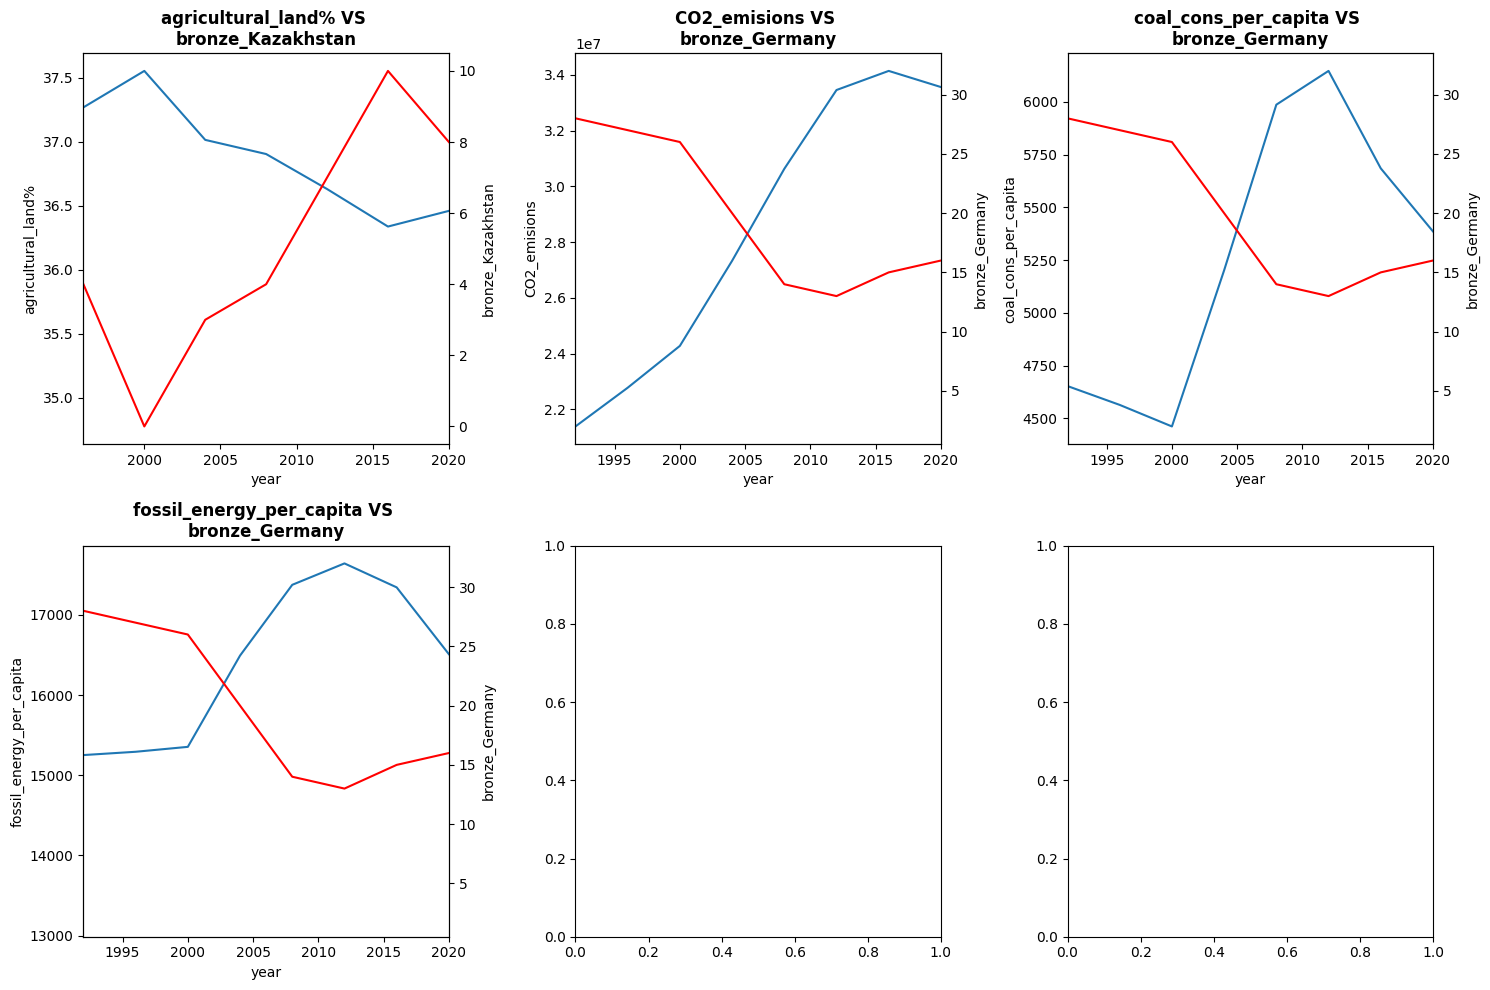

In [47]:
# for each set of 60 results, export to a separate image
for i in range(0, len(results), 60):
    # Export to file
    #plot_results_seaborn(summer_olympics, dict(list(results.items())[i:i+60]), export_path=f"data/exported_data/summer_correlations_{i}.png")
    # Show
    plot_results_seaborn(summer_olympics, dict(list(results.items())[i:i+60]))

### Winter olympics

In [48]:
# Select only numeric columns from the 3rd column (avoid year, and others)

# Test a sample of columns
df_selected = winter_olympics.iloc[:, :300].select_dtypes(include=[np.number])

# Test all columns
#df_selected = winter_olympics.select_dtypes(include=[np.number])

# Convert to NumPy array
df_np = df_selected.to_numpy()

# Get column names
column_names = df_selected.columns.tolist()

# Store start time
import time
start_time = time.time()

# Run autocorrelation function
winter_results = analyze_dataframe(df_np, column_names, lower_thres = 0.95, upper_thres = 0.99, non_comparison_cols = non_comparison_cols)

# Store end time

# Print length of results and time it took to process
print(f"Length of results : {len(winter_results)}")
print(f"Time taken : {time.time() - start_time} seconds")

Length of results : 18
Time taken : 0.3898487091064453 seconds


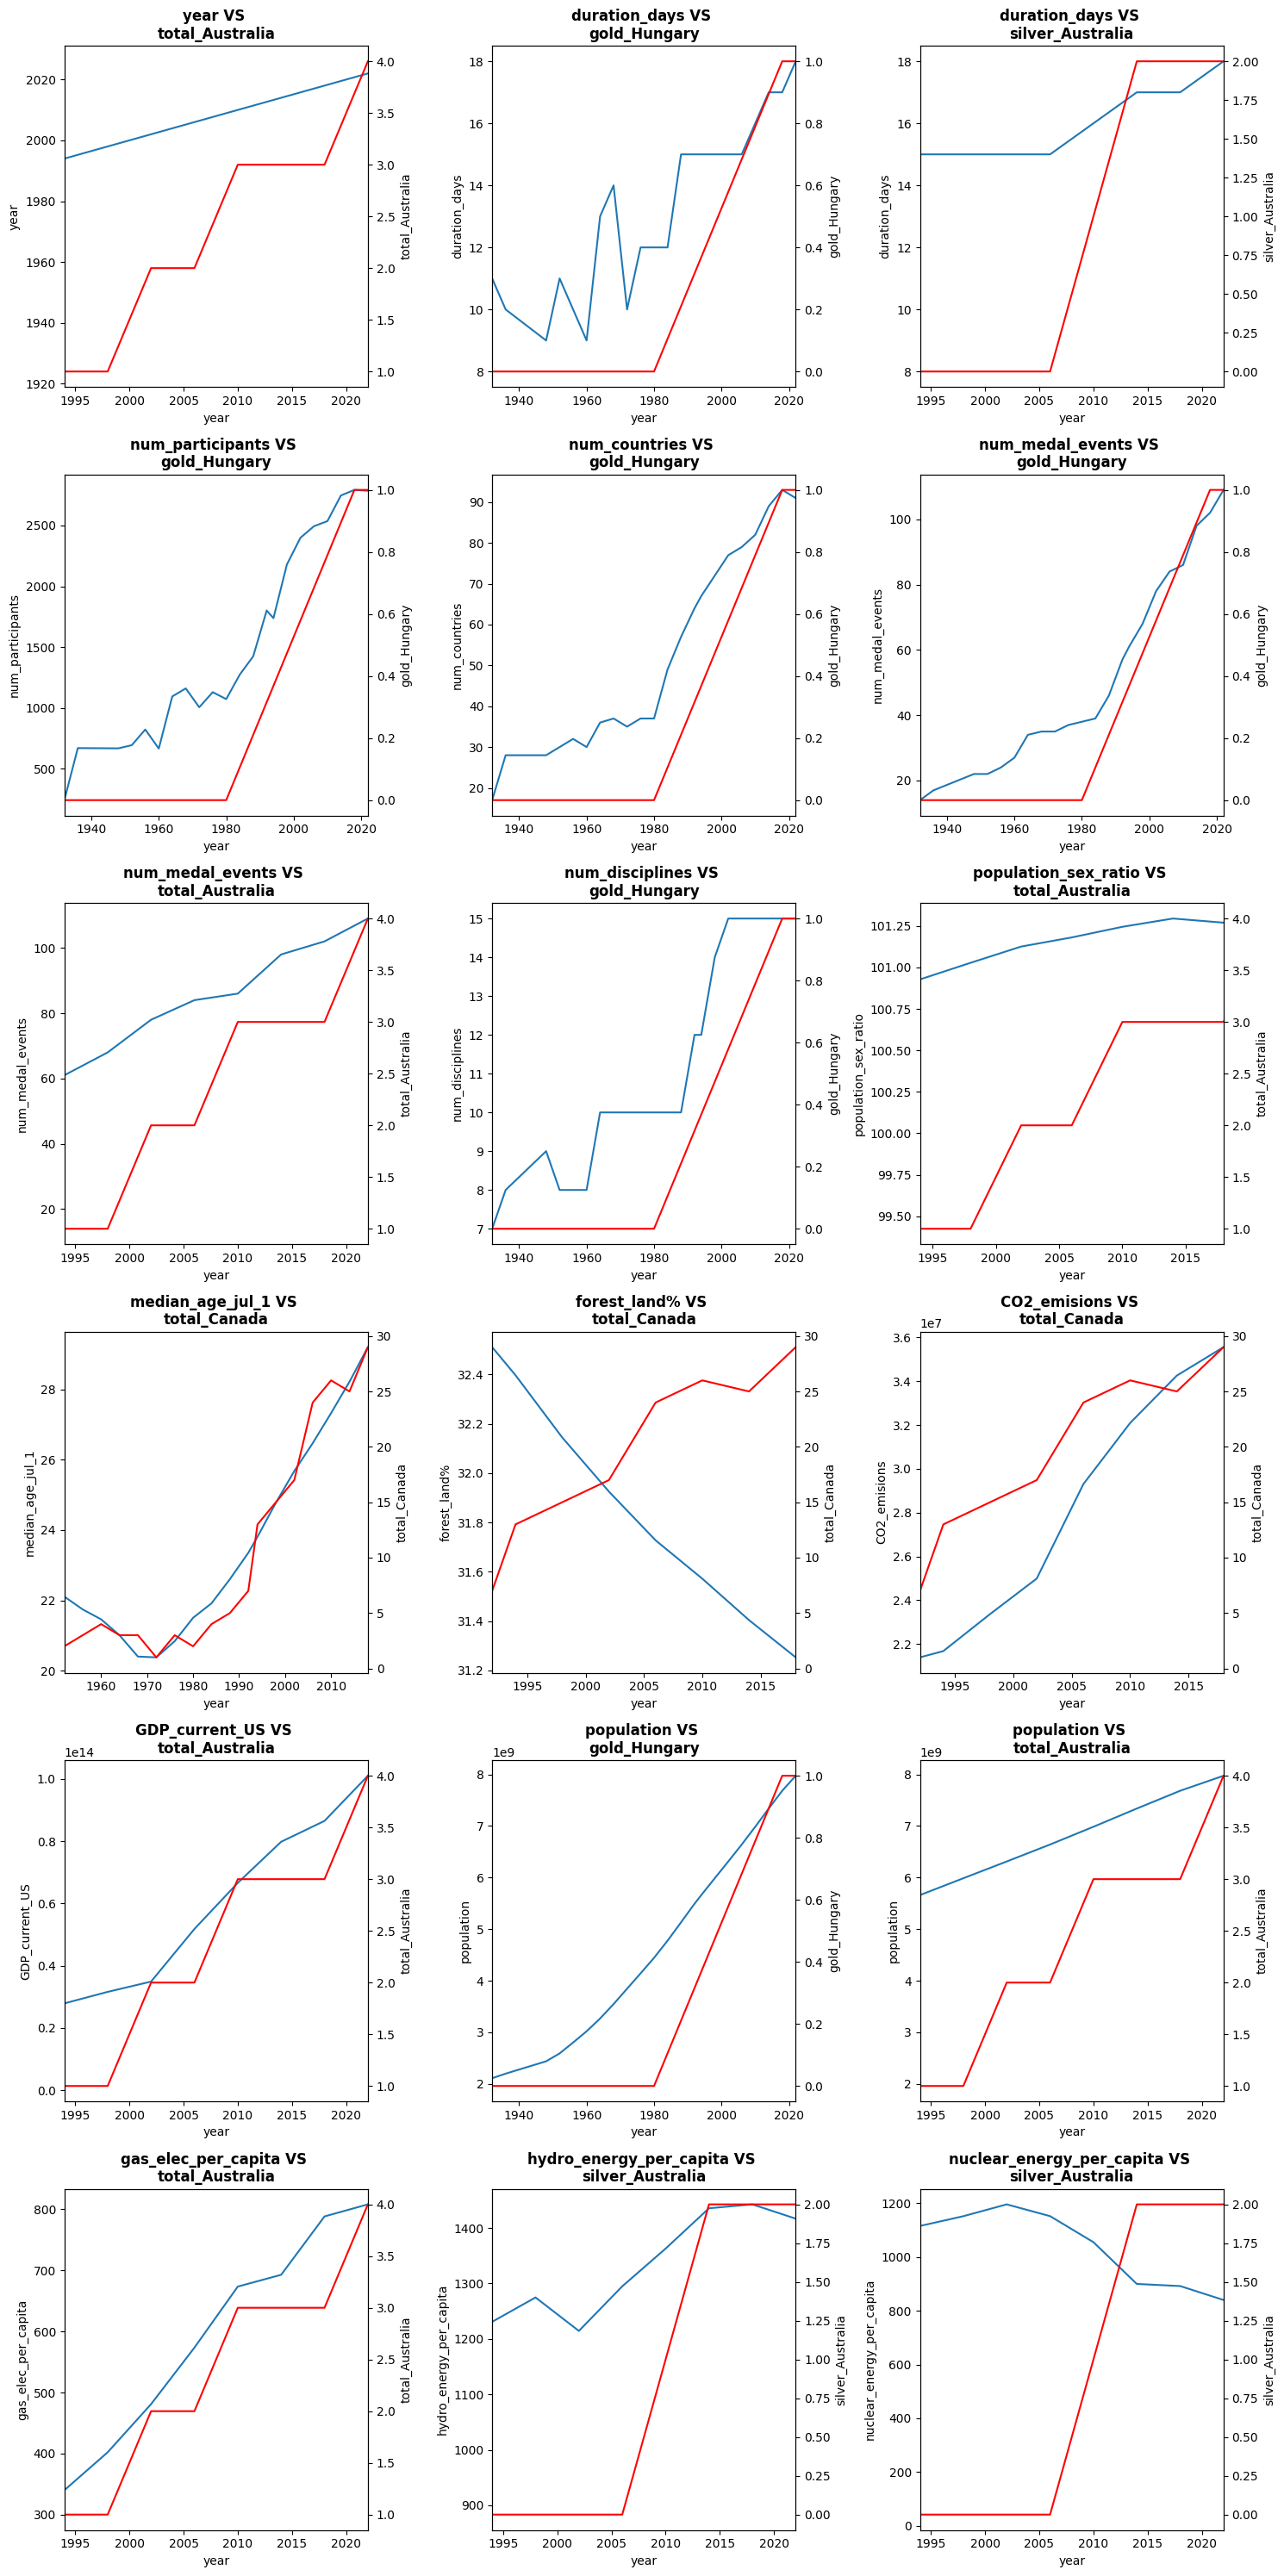

In [49]:
# for each set of 60 results, export to a separate image
for i in range(0, len(winter_results), 60):
    # Export to file
    #plot_results_seaborn(winter_olympics, dict(list(winter_results.items())[i:i+60]), export_path=f"data/exported_data/winter_correlations_{i}.png")
    # Show
    plot_results_seaborn(winter_olympics, dict(list(winter_results.items())[i:i+60]))

## Option 2: calculate correlation between all columns, then manually examine results in Excel and plot relevant graphs by hand

In [50]:
# Create a matrix of Pearson correlations - min_periods represents the minimum number of observations required per pair of columns to have a valid result.
corr_matrix_summer = summer_olympics.corr(numeric_only=True, method = "pearson", min_periods = 15).abs()
corr_matrix_winter = winter_olympics.corr(numeric_only=True, method = "pearson", min_periods = 15).abs()


In [51]:
# only keep certain corr values
def replace_values(val):
    return val if abs(val) >= 0.95 and abs(val) < 0.999 else None

# Apply function and delete columns with no values
corr_matrix_summer = corr_matrix_summer.map(replace_values, na_action='ignore')
corr_matrix_summer = corr_matrix_summer.dropna(axis=1, how='all')
corr_matrix_winter = corr_matrix_winter.map(replace_values, na_action='ignore')
corr_matrix_winter = corr_matrix_winter.dropna(axis=1, how='all')

In [52]:
# Examine in Excel
corr_matrix_summer.to_csv("data/exported_data/corr_matrix_summer.csv")
corr_matrix_winter.to_csv("data/exported_data/corr_matrix_winter.csv")

# Step 4 : plot and examine correlations

In [122]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random
import matplotlib
import plotly.io as py


# Create a chart with the Olympic years on the x axis, and two y-axes representing different data trends 
# You can add a start and end year cutoff for the x axis
# Colours are generated randomly
# You can also provide customer labels for the y-axes

def create_dual_axis_chart(dataframe, y1_column, y2_column, title, x_axis_title="Year", y1_axis_title=None, y2_axis_title=None, 
                           y1_axis_labels = None, y2_axis_labels = None,
                           start_year=None, end_year=None, filename = None):
    # Filter dataframe if start_year and end_year are specified
    if start_year is not None or end_year is not None:
        dataframe = dataframe[(dataframe['year'] >= start_year) & (dataframe['year'] <= end_year)]

    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Generate random colors for the lines
    color_y1 = random.choice(list(matplotlib.colors.cnames.values()))
    color_y2 = random.choice(list(matplotlib.colors.cnames.values()))

    # Add traces with the generated colors
    fig.add_trace(
        go.Scatter(x=dataframe['year'], y=dataframe[y1_column], 
                   text = y1_axis_labels, textposition = "top center",
                   name=y1_column, 
                   mode='lines+markers+text',
                   line=dict(width=4, color=color_y1)), secondary_y=False
    )

    fig.add_trace(
        go.Scatter(x=dataframe['year'], y=dataframe[y2_column], 
                   text = y2_axis_labels, textposition = "top center",
                   name=y2_column, 
                   mode='lines+markers+text',
                   line=dict(width=4, color=color_y2)), secondary_y=True,
    )

    # Add figure title
    fig.update_layout(
        title_text=title
    )

    # Set x-axis title
    fig.update_xaxes(title_text=x_axis_title, tickmode='array', tickvals = dataframe['year'].unique())
    fig.update_traces(connectgaps=True, marker={'size': 13, 'symbol' : 'square'})
    
    # Set y-axes titles with the same colors as the lines
    fig.update_yaxes(title_text=f"<b>{y1_axis_title}</b>", titlefont=dict(color=color_y1), secondary_y=False)

    # Automatically set the y2 axis rounding mode
    if dataframe[y2_column].max() <= 100:
        tickformat = ".0f"
    else:
        tickformat = ".2s" 

    fig.update_yaxes(title_text=f"<b>{y2_axis_title}</b>", titlefont=dict(color=color_y2), secondary_y=True, tickmode = "sync", tickformat = tickformat)

    # Separate title into lines
    title_with_breaks = title.replace('\n', '<br>')

    fig.update_layout(
        showlegend=False,
        title_text=f"<b>{title_with_breaks}</b>", 
        title_x=0.5,  # Center the title
        autosize=False,
        width=1000, 
        height=550,  
        template="ggplot2"  # Apply theming
    )

    # If a filename is provided, export the figure to a static image file
    if filename is not None:
        py.write_image(fig, f'graph_examples/{filename}.png', scale = 5)

    fig.show()

### Manual examples

In [136]:
create_dual_axis_chart(summer_olympics, "total_People's Republic of China", 'max_athlete_age_Kayak_Singles__500_metres__Women', 
                       title = "Chinese medals vs \n oldest athlete competing in the Women 1500 Kayak Singles", 
                       x_axis_title="Summer Olympic Edition", 
                       y1_axis_title="Total medals earned by PRC", 
                       y2_axis_title="Max age of women in Kayak Singles (500 m.) event",
                       start_year=1984, 
                       end_year=2020, 
                       filename = "chinese_kayak")

In [138]:
create_dual_axis_chart(summer_olympics, "gold_Czechia", 'count_steven', 
                       title = "Number of athletes named Steven VS \n Gold medals earned by Czechia", 
                       x_axis_title="Summer Olympic Year", 
                       y1_axis_title="Total medals earned by Czechia",
                       y2_axis_title="Number of athletes named Steven",
                       start_year=1998, 
                       end_year=2020,
                       filename = "czechia_steven")

In [130]:
# Store city names
cities = ["Atlanta", "Sydney", "Athina", "Beijing", "London", "Rio de Janeiro", "Tokyo"]

# Dual axis chart
create_dual_axis_chart(summer_olympics, 'total_Kazakhstan', 'host_city_len', 
                       title= "Total medals earned by Kazakhstan VS \n Number of letters in the host city name",
                       x_axis_title="Summer Olympic Year", 
                       y1_axis_title="Total medals earned by Kazakhstan", 
                       y2_axis_title="Length of host city name",
                       y2_axis_labels = cities,
                       start_year=1996, 
                       end_year=2020,
                       filename = "kazakhstan_host_city")


In [140]:
create_dual_axis_chart(summer_olympics, 'mean_Artistic Gymnastics_athlete_age', 'CO2_emisions', 
                       title= "Average age of Artistic Gymnastics athletes VS \n CO2 emissions in metric tons",
                       x_axis_title="Summer Olympic Year", 
                       y1_axis_title="Average age of Artistic Gymnastics athletes",
                       y2_axis_title="CO2 emissions in kilotons",
                       start_year=1992, 
                       end_year=2020,
                       filename = "gymnastics_co2")


In [143]:
create_dual_axis_chart(summer_olympics, "fossil_energy_per_capita", 'count_ryan', 
                       title = "Number of athletes named Ryan VS \n Fossil fuel consumption", 
                       x_axis_title="Summer Olympic Year", 
                       y1_axis_title="Fossil fuel consumption per capita (kwH)",
                       y2_axis_title="Number of athletes named Ryan",
                       start_year=1992, 
                       end_year=2020,
                       filename = "ryan_carbon")

In [149]:
create_dual_axis_chart(summer_olympics, "distance_from_athens_km", 'count_gina', 
                       title = "Athletes named Gina vs \n Distance from Athens", 
                       x_axis_title="Summer Olympic Year", 
                       y1_axis_title="Distance of host city from Athens in a straight line (km)",
                       y2_axis_title="Number of athletes named Gina",
                       start_year=1992, 
                       end_year=2020,
                       filename = "gina_distance")